In [1]:
import sys
sys.path.append(r"C:\Users\eg38emed\FCD\FCD vs TSC\keras_utils")
import tensorflow as tf
import keras
from image.image_data_generator import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array
from image.directory_iterator import DirectoryIterator
from image.dataframe_iterator import DataFrameIterator

Using TensorFlow backend.


Sequence


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical # get categorical labels

from keras.models import Sequential, Model
from keras import optimizers, applications
from keras import backend
from keras.layers import GlobalMaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, AveragePooling2D, Concatenate
from keras.metrics import categorical_accuracy
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint, Callback, LambdaCallback, CSVLogger
from helper import *

auc_roc = as_keras_metric(tf.metrics.auc)

In [2]:
from augmentation import *

In [6]:
model_name = 'VGG_GRADCAM'
PATH = (r'C:\Users\eg38emed\FCD\base_dir_fold_4\\')

base_path = (r'C:\Users\eg38emed\FCD\base_dir_fold_4\{}'.format(model_name))
if not os.path.exists(base_path):
    os.makedirs(base_path)
    print('Made PATH: {}'.format(base_path))
else:
    print("PATH already exists!")

train_path = (PATH + 'train_dir')
val_path = (PATH + 'val_dir')
#val_path = (r'D:\Doktorarbeit\FCD\kfold_RCZ\base_dir_fold_8\val_dir')

PATH already exists!


In [8]:
IMAGE_SIZE = 100
IMAGE_CHANNELS = 3
train_batch_size_1 = 128
val_batch_size = 64
seq = get_seq()

datagen_train = ImageDataGenerator(preprocessing_function=seq.augment_image,
                                   #rotate_random_zoom_crop=True,
                                   rescale=1./255)

datagen_val = ImageDataGenerator(rescale=1./255
                                #rotate_random_zoom_crop=True
                                )

train_gen_1 = DirectoryIterator(train_path, datagen_train,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        #crop_size = (100, 100),
                                        batch_size=train_batch_size_1,
                                        class_mode='categorical')

val_gen = DirectoryIterator(val_path,
                            datagen_val,
                            target_size=(IMAGE_SIZE,IMAGE_SIZE),
                            #crop_size = (100, 100),
                            batch_size=val_batch_size,
                            class_mode='categorical')

num_train_samples = train_gen_1.samples
num_val_samples = val_gen.samples
print(num_train_samples)
print(num_val_samples)

Found 4322 images belonging to 2 classes.
Found 482 images belonging to 2 classes.
4322
482


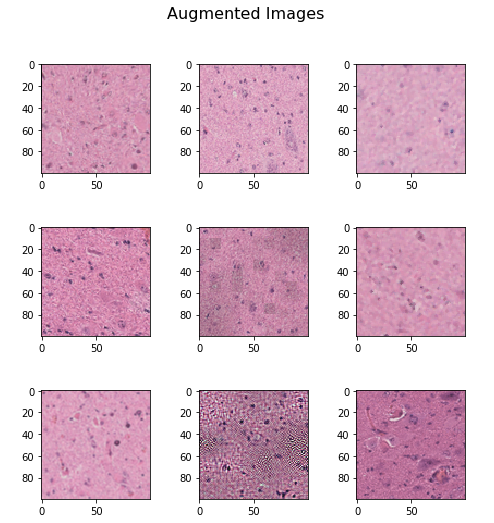

<Figure size 500x500 with 0 Axes>

In [14]:
looking_at_augmentation(train_gen_1, batchsize=9, path=base_path)

In [15]:
#VGG-16 with BatchNorm + 2. Denselayer
def get_model_classif_VGG_base_nottrainable():
    base_model_VGG = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    print('Model loaded.')
    
    for layer in base_model_VGG.layers:
        layer.trainable = False
    print("trainable: ONLY toplayer")
    
    x = base_model_VGG.output
    out = GlobalMaxPooling2D(name='1')(x)
    x = BatchNormalization(name='2')(out)
    x = Dropout(0.5, name='3')(x)
    x = Dense(512, activation='relu',name='4') (x)
    x = BatchNormalization(name='5')(x)
    x = Dropout(0.2, name='6')(x)
    x = Dense(256, activation='relu',name='7') (x)
    x = BatchNormalization(name='8')(x)
    
    predictions = (Dense(2, activation='softmax'))(x)
    model_VGG = Model(inputs=base_model_VGG.input, outputs=predictions)

    adam = optimizers.Adam()
    model_VGG.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=[categorical_accuracy, auc_roc])

    model_VGG.summary()
    return model_VGG

def get_model_classif_VGG_base_trainable():
    base_model_VGG = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    print('Model loaded.')
    
    for layer in base_model_VGG.layers:
        layer.trainable = True
    print("trainable: WHOLE model")
    
    x = base_model_VGG.output
    out = GlobalMaxPooling2D(name='1')(x)
    x = BatchNormalization(name='2')(out)
    x = Dropout(0.5, name='3')(x)
    x = Dense(512, activation='relu',name='4') (x)
    x = BatchNormalization(name='5')(x)
    x = Dropout(0.5, name='6')(x)
    x = Dense(256, activation='relu',name='7') (x)
    x = BatchNormalization(name='8')(x)
    
    predictions = (Dense(2, activation='softmax'))(x)
    model_VGG = Model(inputs=base_model_VGG.input, outputs=predictions)

    adam = optimizers.Adam()
    model_VGG.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=[categorical_accuracy, auc_roc])

    model_VGG.summary()
    return model_VGG

# Training Toplayers

In [9]:
model_VGG = get_model_classif_VGG_base_nottrainable()
#model_VGG.load_weights('C:\Users\eg38emed\FCD\Models\VGG_dataset2_clr\VGG_dataset2_clr.h5')

Model loaded.
trainable: input_1
trainable: block1_conv1
trainable: block1_conv2
trainable: block1_pool
trainable: block2_conv1
trainable: block2_conv2
trainable: block2_pool
trainable: block3_conv1
trainable: block3_conv2
trainable: block3_conv3
trainable: block3_pool
trainable: block4_conv1
trainable: block4_conv2
trainable: block4_conv3
trainable: block4_pool
trainable: block5_conv1
trainable: block5_conv2
trainable: block5_conv3
trainable: block5_pool
Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block

In [ ]:
from keras_lr_finder import LRFinder
lr_gen = datagen_train.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        #crop_size = (100,100),
                                        batch_size=2000,
                                        class_mode='categorical')

x_lr_train,y_lr_train= lr_gen.next()
print(x_lr_train.shape)
lr_finder = LRFinder(model_VGG)

lr_finder.find(x_lr_train, y_lr_train, 1e-9, 10, batch_size=128, epochs=4)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

In [10]:
import clr_callback
def get_callbacks_clr(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    clr = clr_callback.CyclicLR(base_lr=0.0001, max_lr=0.001,
                        step_size=num_train_samples/train_batch_size_1/2)
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_toplayer.csv".format(model_name), append=True)
    return [clr, earlystopping, ReduceLR, checkpoint, csv_logger]

def get_callbacks(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_toplayer.csv".format(model_name), append=True)
    return [earlystopping, ReduceLR, checkpoint, csv_logger]

name_weights = (base_path + "\\{}_toplayer.h5".format(model_name))
callbacks_list = get_callbacks_clr(name_weights = name_weights)

In [11]:
#model_VGG.load_weights(base_path + "\\{}.h5".format(model_name))
history = model_VGG.fit_generator(train_gen_1, 
                    steps_per_epoch=len(train_gen_1), 
                    validation_data=val_gen,
                    validation_steps=len(val_gen),
                    epochs=20, verbose=1,
                    use_multiprocessing = False, workers = 6, 
                    callbacks=callbacks_list)

plot_history(history, modelname = model_name, path=base_path)

Epoch 1/20
680/680 [==============================] - 4750s 7s/step - loss: 0.7110 - categorical_accuracy: 0.5761 - auc_roc: 0.5774 - val_loss: 0.5558 - val_categorical_accuracy: 0.7348 - val_auc_roc: 0.6140

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73479, saving model to D:\Doktorarbeit\FCD\kfold_RCZ\base_dir_fold_8\VGG_RCZ_8\VGG_RCZ_8_toplayer.h5
Epoch 2/20
680/680 [==============================] - 4650s 7s/step - loss: 0.6573 - categorical_accuracy: 0.6033 - auc_roc: 0.6307 - val_loss: 0.5793 - val_categorical_accuracy: 0.6953 - val_auc_roc: 0.6389

Epoch 00002: val_categorical_accuracy did not improve from 0.73479
Epoch 3/20
680/680 [==============================] - 4638s 7s/step - loss: 0.6508 - categorical_accuracy: 0.6077 - auc_roc: 0.6446 - val_loss: 0.5668 - val_categorical_accuracy: 0.7056 - val_auc_roc: 0.6494

Epoch 00003: val_categorical_accuracy did not improve from 0.73479
Epoch 4/20
680/680 [==============================] - 4626s 7s/step - loss: 

KeyboardInterrupt: 

# Training baselayers

In [18]:
#FINETUNE ALL VGG
IMAGE_SIZE = 272
IMAGE_CHANNELS = 3
train_batch_size_1 = 64
val_batch_size = 64
seq = get_seq()

datagen_train = ImageDataGenerator(preprocessing_function=seq.augment_image,
                                   #rotate_random_zoom_crop=True,
                                   rescale=1./255)

datagen_val = ImageDataGenerator(rescale=1./255
                                #rotate_random_zoom_crop=True
                                )

train_gen_1 = DirectoryIterator(train_path, datagen_train,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        #crop_size = (100, 100),
                                        batch_size=train_batch_size_1,
                                        class_mode='categorical')

val_gen = DirectoryIterator(val_path,
                            datagen_val,
                            target_size=(IMAGE_SIZE,IMAGE_SIZE),
                            #crop_size = (100, 100),
                            batch_size=val_batch_size,
                            class_mode='categorical')

num_train_samples = train_gen_1.samples
num_val_samples = val_gen.samples

print(num_train_samples)
print(num_val_samples)

model_VGG = get_model_classif_VGG_base_trainable()
#model_VGG.load_weights(base_path + "\\{}_100_ALL.h5".format(model_name))

Model loaded.
trainable: input_2
trainable: block1_conv1
trainable: block1_conv2
trainable: block1_pool
trainable: block2_conv1
trainable: block2_conv2
trainable: block2_pool
trainable: block3_conv1
trainable: block3_conv2
trainable: block3_conv3
trainable: block3_pool
trainable: block4_conv1
trainable: block4_conv2
trainable: block4_conv3
trainable: block4_pool
trainable: block5_conv1
trainable: block5_conv2
trainable: block5_conv3
trainable: block5_pool
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool 

In [13]:
from keras_lr_finder import LRFinder
lr_gen = datagen_train.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        #crop_size = (100,100),
                                        batch_size=2500,
                                        class_mode='categorical')

x_lr_train,y_lr_train= lr_gen.next()
print(x_lr_train.shape)
lr_finder = LRFinder(model_VGG)

Found 4324 images belonging to 2 classes.
(3000, 100, 100, 3)


no list
Epoch 1/4
3000/3000 [==============================] - 8s 3ms/step - loss: 1.0326 - categorical_accuracy: 0.4937 - auc_roc: 0.4644
Epoch 2/4
3000/3000 [==============================] - 5s 2ms/step - loss: 0.9550 - categorical_accuracy: 0.5220 - auc_roc: 0.5064
Epoch 3/4
3000/3000 [==============================] - 5s 2ms/step - loss: 0.9178 - categorical_accuracy: 0.5237 - auc_roc: 0.5097
Epoch 4/4
3000/3000 [==============================] - 5s 2ms/step - loss: 0.9562 - categorical_accuracy: 0.5027 - auc_roc: 0.5089


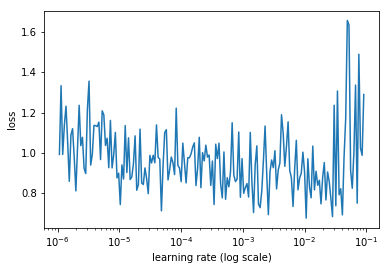

In [14]:
lr_finder.find(x_lr_train, y_lr_train, 1e-9, 10, batch_size=64, epochs=4)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

In [ ]:
#clr.reset()

In [19]:
import clr_callback
def get_callbacks_clr(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.25, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    clr = clr_callback.CyclicLR(base_lr=0.000005, max_lr=0.00005,
                        step_size=num_train_samples/train_batch_size_1/2)
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_ALL.csv".format(model_name), append=True)
    return [clr, earlystopping, ReduceLR, checkpoint, csv_logger]

def get_callbacks(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.25, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_ALL.csv".format(model_name), append=True)
    return [earlystopping, ReduceLR, checkpoint, csv_logger]

name_weights = (base_path + "\\{}_ALL.h5".format(model_name))
callbacks_list = get_callbacks_clr(name_weights = name_weights)

In [20]:
model_VGG.load_weights(base_path + "\\{}_toplayer.h5".format(model_name))
history = model_VGG.fit_generator(train_gen_1, 
                    steps_per_epoch=len(train_gen_1), 
                    validation_data=val_gen,
                    validation_steps=len(val_gen),
                    epochs=40, verbose=1,
                    use_multiprocessing = False, workers = 6, 
                    callbacks=callbacks_list)

plot_history(history, modelname = model_name, path=base_path)

Epoch 1/20
680/680 [==============================] - 2065s 3s/step - loss: 0.4937 - categorical_accuracy: 0.7455 - auc: 0.7822 - val_loss: 1.3232 - val_categorical_accuracy: 0.5754 - val_auc: 0.8167

Epoch 00001: val_categorical_accuracy improved from -inf to 0.57541, saving model to C:\Users\eg38emed\FCD\kfold_RCZ\base_dir_fold_1\VGG_RCZ_1\VGG_RCZ_1_ALL.h5
Epoch 2/20
680/680 [==============================] - 2033s 3s/step - loss: 0.3801 - categorical_accuracy: 0.8174 - auc: 0.8311 - val_loss: 1.6091 - val_categorical_accuracy: 0.5310 - val_auc: 0.8436

Epoch 00002: val_categorical_accuracy did not improve from 0.57541
Epoch 3/20
680/680 [==============================] - 2029s 3s/step - loss: 0.3368 - categorical_accuracy: 0.8418 - auc: 0.8508 - val_loss: 0.9505 - val_categorical_accuracy: 0.4949 - val_auc: 0.8611

Epoch 00003: val_categorical_accuracy did not improve from 0.57541
Epoch 4/20
680/680 [==============================] - 2030s 3s/step - loss: 0.3034 - categorical_accura

KeyboardInterrupt: 

In [ ]:
plot_history(history, modelname = model_name, path=base_path)

## Model Evaluation

In [ ]:
# Setup the data_frame: Path, ID, Label, Image
tiles = (r"C:\Users\eg38emed\FCD\Tiles_RCZ")
test_path = tiles + '\\Validation'
print(test_path)

fcd = test_path +  '\\a_fcd'
tsc = test_path + '\\b_tsc'
print('FCD Path:' fcd)
#fcd folder
df = pd.DataFrame({'path': glob(os.path.join(fcd,'*.png'))})
df['id'] = df.path.map(lambda x: x.split('\\')[6].split('.')[0]) 
df['label'] = 0

#tsc folder
df_pos = pd.DataFrame({'path': glob(os.path.join(tsc,'*.png'))})
df_pos['id'] = df_pos.path.map(lambda x: x.split('\\')[6].split('.')[0]) 
df_pos['label'] = 1

#both
df_train = pd.concat([df, df_pos])

#add images
df_train['image'] = df_train['path'].map(imread)

print(len(df_train))
print(df_train.head())

#extracting images out of df
imgs = []
for img in df_train['image']:
    imgs.append(img)
        
X = np.asarray(imgs)
y = to_categorical(df_train['label'])

print(X.shape)
print(y.shape)

In [ ]:
batch_size= 1
datagen_test = ImageDataGenerator(rescale=1./255,
                                rotate_random_zoom_crop=True)

test_generator = datagen_test.flow_from_directory(test_path, 
                                                  batch_size = batch_size, 
                                                  shuffle=False,#FALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSE
                                                  #target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                  crop_size = (100,100),
                                                  class_mode='categorical')

In [ ]:
#evaluate model on validation-data + test_datagen --> weights of best training epoch will be used
model_VGG = get_model_classif_VGG_base_trainable()
#model_VGG.load_weights(base_path + "\\VGG_kfold_4_ALL.h5")
model_VGG.load_weights(base_path + "\\VGG_RCZ_100_DO0.5_ALL.h5")
val_loss, val_acc, auc_roc = \
model_VGG.evaluate_generator(test_generator, 
                             steps=len(test_generator),
                             verbose=1,
                             workers = 6,
                             use_multiprocessing = False)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

In [ ]:
test_generator.reset()

In [ ]:
predictions = model_VGG.predict_generator(test_generator, 
                                          steps=len(test_generator), 
                                          workers=6, 
                                          use_multiprocessing=False, 
                                          verbose=1)

In [ ]:
# Get the true labels
y_label = np.argmax(y, axis=1)
print(y_label)
df_preds = pd.DataFrame(predictions, columns=['FCD', 'TSC'])
print(df_preds.head())
# Get the predicted labels as probabilities
y_pred = df_preds['TSC']

In [ ]:
#maybe change pos/neg cutoff:
plot_roc(y_label, y_pred, modelname=model_name, path = base_path)

In [ ]:
cm = confusion_matrix(y_label, y_pred.round())
cm_plot_labels = ['FCD', 'TSC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix VGG')

In [ ]:
#rounding predictions + make them int --> compare to label / heatmap
y_pred = y_pred.round()
y_pred_int = []
for i in y_pred:
    if i == 1.0:
        y_pred_int.append(1)
    else:
        y_pred_int.append(0)

y_pred_int = np.asarray(y_pred_int)
print((y_pred_int.shape))

In [ ]:
plot_correct(X, y_pred_int, y_label, modelname=model_name, path=base_path)
plot_incorrect(X, y_pred_int, y_label, modelname=model_name, path=base_path)

In [ ]:
filenames = test_generator.filenames
incorrect = np.where(y_pred!=y_label)[0]
for i, incorrect in enumerate(incorrect):
    print(incorrect)
    print(filenames[incorrect])

In [ ]:
from  keras.preprocessing  import image

def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=10)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plots_idx(idx, titles=None):
    plots([image.load_img(test_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 10

In [ ]:
#3a. The images we most confident were FCD, and are actually FCD
correct_fcd = np.where((y_label==0) & (y_label==y_pred_int))[0]
print("Found %d confident correct FCD labels" % len(correct_fcd))
most_correct = np.argsort(y_predictions[correct_fcd])[:n_view]

plots_idx(correct_fcd[most_correct], y_predictions[correct_fcd][most_correct])

In [ ]:
#3b. The images we most confident were TSC, and are actually TSC
correct_tsc = np.where((y_label==1) & (y_label==y_pred_int))[0]
print("Found %d confident correct TSC labels" % len(correct_tsc))
most_correct_tsc = np.argsort(y_predictions[correct_tsc])[::-1][:20]
plots_idx(correct_tsc[most_correct_tumor], y_predictions[correct_tsc][most_correct_tsc])

In [ ]:
#4a. The images we were most confident were FCD, but are actually TSC
incorrect_fcd = np.where((y_label==1) & (y_pred_int!=y_label))[0]
print("Found %d incorrect TSC" % len(incorrect_fcd))
if len(incorrect_fcd):
    most_incorrect_fcd = np.argsort(y_predictions[incorrect_fcd])[:n_view]
    plots_idx(incorrect_fcd[most_incorrect_fcd], y_predictions[incorrect_fcd][most_incorrect_fcd])

In [ ]:
#4b. The images we were most confident were TSC, but are actually FCD
incorrect_tsc = np.where((y_label==0) & (y_pred_int!=y_label))[0]
print("Found %d incorrect FCD" % len(incorrect_tsc))
if len(incorrect_tsc):
    most_incorrect_tsc = np.argsort(y_predictions[incorrect_tsc])[::-1][:n_view]
    plots_idx(incorrect_tsc[most_incorrect_tsc], y_predictions[incorrect_tsc][most_incorrect_tsc])

In [ ]:
#5. The most uncertain labels (probability closest to 0.5).
most_uncertain = np.argsort(np.abs(y_predictions-0.5))
plots_idx(most_uncertain[:n_view], y_predictions[most_uncertain])